A rough copy of https://pyimagesearch.com/2021/10/25/training-a-dcgan-in-pytorch/

In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from datasets import fetch_mnist
torch.manual_seed(1337)

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.ct1 = nn.ConvTranspose2d(100, 128, 4, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.ct2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.ct3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.ct4 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1, bias=False)
    
    def __call__(self, x):
        out = self.bn1(F.relu(self.ct1(x)))
        out = self.bn2(F.relu(self.ct2(out)))
        out = self.bn3(F.relu(self.ct3(out)))
        out = torch.tanh(self.ct4(out))
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def __call__(self, x):
        out = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        out = F.leaky_relu(self.conv2(out), negative_slope=0.2)
        out = out.reshape(out.shape[0], -1)
        out = F.leaky_relu(self.fc1(out), negative_slope=0.2)
        out = torch.sigmoid(self.fc2(out))
        return out

In [3]:
def weights_init(model):
    class_name = model.__class__.__name__
    if class_name.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    if class_name.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)


def train_generator(fake_data):
    labels = torch.ones(batch_size, dtype=torch.float)
    output = discriminator(fake_data).reshape(-1)
    loss = criterion(output, labels)
    optimizer_g.zero_grad()
    loss.backward()
    optimizer_g.step()
    return loss.item()


def train_discriminator(real_data, fake_data):
    real_output = discriminator(real_data).reshape(-1)
    fake_output = discriminator(fake_data).reshape(-1)
    real_labels = torch.ones(batch_size, dtype=torch.float)
    fake_labels = torch.zeros(batch_size, dtype=torch.float)
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    optimizer_d.zero_grad()
    real_loss.backward()
    fake_loss.backward()
    optimizer_d.step()
    return (real_loss + fake_loss).item()

g_loss 4.40 d_loss 0.05: 100%|██████████| 546/546 [01:18<00:00,  6.94it/s]


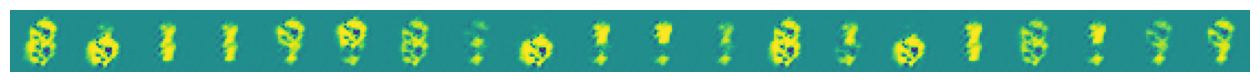

g_loss 4.20 d_loss 0.07: 100%|██████████| 546/546 [01:17<00:00,  7.04it/s] 


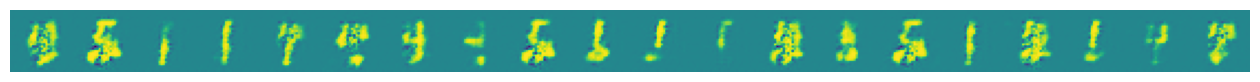

g_loss 8.70 d_loss 0.24: 100%|██████████| 546/546 [01:18<00:00,  6.94it/s] 


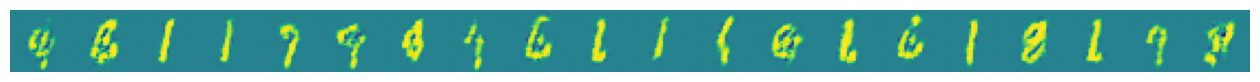

g_loss 5.64 d_loss 0.03: 100%|██████████| 546/546 [01:17<00:00,  7.03it/s] 


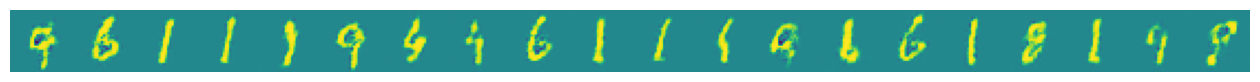

In [4]:
epochs, batch_size = 20, 128
sample_interval = epochs // 4
criterion = nn.BCELoss()

X = np.vstack(fetch_mnist()[::2]).reshape(-1, 1, 28, 28) / 255.0 
steps = X.shape[0] // batch_size
benchmark_noise = torch.randn(20, 100, 1, 1, requires_grad=False)

generator, discriminator = Generator(), Discriminator()
generator.apply(weights_init)
discriminator.apply(weights_init)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, weight_decay=0.0002/epochs)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.0002/epochs)

for i in range(epochs):
    for _ in (t := trange(steps)):
        sample = np.random.randint(0, high=X.shape[0], size=(batch_size))
        real_images = torch.tensor(X[sample])
        fake_images = generator(torch.randn(batch_size, 100, 1, 1))
        d_loss = train_discriminator(real_images, fake_images.detach())
        g_loss = train_generator(fake_images)
        t.set_description(f"g_loss {g_loss:.2f} d_loss {d_loss:.2f}")
    if (i + 1) % sample_interval == 0:
        plt.figure(figsize=(16, 5))
        images = generator(benchmark_noise).detach().numpy()
        plt.imshow(np.hstack(images.reshape(-1, 28, 28)))
        plt.axis("off")
        plt.show()